# Artificial Intelligence for Games
- [Udemy Course](https://derivco.udemy.com/course/artificial-intelligence-for-simple-games/)

### Environment Setup

In [2]:
%run ./fa.intelligence.notebooks/utilities/reinforcement_learning/environments/crypto_pair_trading_environment.ipynb

In [3]:
import pickle

In [4]:
model_file_path = './data/featurized_market_data.p' 

with open(model_file_path, 'rb') as fp:
    featurized_market_data = pickle.load(fp)

In [5]:
pair_name = 'AAVE_BTC'
pair_data = featurized_market_data[pair_name]

# This dataset contains open, close, high, low, volume and any numerical features / indicators you like.
price_movement_df = pair_data

In [6]:
env = CryptoPairTradingEnv(pair_data, pair_name)

### Genetic Algorithms

#### Imports

In [7]:
import time
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from IPython import display

#### Configuration

#### Utilities

In [8]:
class Chromosome():
    def __init__(self, genes, genome_length, fitness=0, default_gene=0):
        self.genes = genes.copy()
        self.genome_length = genome_length
        self.default_gene = default_gene
        self.fitness = fitness
        
        while len(self.genes) < genome_length:
            self.genes.append(default_gene)
            
    def crossover(self, mate, min_gene_value, max_gene_value, mutation_rate=0.1):
        offspring_genes = []
        
        # Simple cross-over function based on a 50% probability to take either parent's genes.
        for gene_index in range(self.genome_length):
            if np.random.rand() <= 0.5:
                offspring_genes.append(self.genes[gene_index])
            else:
                offspring_genes.append(mate.genes[gene_index])
                
        # Mutation
        for gene_index in range(self.genome_length):
            if np.random.rand() <= mutation_rate:
                offspring_genes[gene_index] = np.random.randint(low=min_gene_value, high=(max_gene_value + 1))
        
        return Chromosome(offspring_genes, self.genome_length, self.default_gene)

In [9]:
class GeneticEnvOptimizer():
    def __init__(self, env, min_gene_value, max_gene_value, population_size=100):
        self.population_size = population_size
        self.env = env
        self.min_gene_value = min_gene_value
        self.max_gene_value = max_gene_value
        self.__reset__()

    def __reset__(self):
        self.population = self.__generate_population__(self.population_size)

    def __generate_population__(self, population_size):
        print(f'Generating a population size of {population_size}.')
        
        population = []
        
        for index in range(population_size):
            state = env.reset()
            done = False
            actions = []
            episode_reward = 0
            
            while not done:
                action = env.action_space.sample()
                state, reward, done, info = env.step(action)
                episode_reward += reward
                actions.append(action)
                
            population.append(Chromosome(actions, env.data.shape[0] - 1, fitness=episode_reward))
            
        return population

    def __calculate_population_fitness__(self, population):
        for genome in population:
            state = env.reset()
            done = False
            actions = []
            episode_reward = 0
            
            while not done:
                action = env.action_space.sample()
                state, reward, done, info = env.step(action)
                episode_reward += reward
                actions.append(action)
                
            genome.fitness = episode_reward

    def __genome_sorting_key__(self, genome):
        return genome.fitness

    def __population_by_highest_fitness_in_place__(self):
        self.population.sort(key=self.__genome_sorting_key__, reverse=True)

    def __perform_selection__(self, population):
        new_population = []
        
        for left_parent_genome in population:
            for right_parent_genome in population:
                new_population.append(left_parent_genome.crossover(right_parent_genome, min_gene_value=self.min_gene_value, max_gene_value=self.max_gene_value))
        
        self.__calculate_population_fitness__(new_population)
        new_population.sort(key=self.__genome_sorting_key__, reverse=True)
        return new_population[:self.population_size]

    def optimize(self, is_initial_run=False):
        if is_initial_run:
            self.__reset__()

        self.__population_by_highest_fitness_in_place__()
        offspring = self.__perform_selection__(self.population)
        self.population = self.population[:3] + offspring[3:len(offspring)-3]

In [10]:
optimizer = GeneticEnvOptimizer(env, population_size=25, min_gene_value=min([ key.value for key in Actions ]), max_gene_value=max([ key.value for key in Actions ]))
generations = 50000
fitness_scores = []

Generating a population size of 25.


C:\ProgramData\miniforge3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


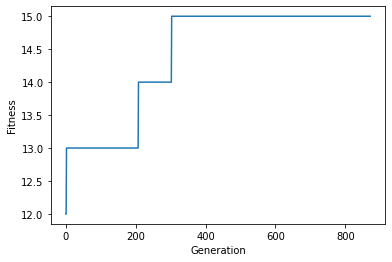

In [11]:
for generation_index in range(generations):
    optimizer.optimize()#is_initial_run=generation_index==0)
    fitness_scores.append(optimizer.population[0].fitness)
    fig, (ax1) = plt.subplots(1)
    ax1.plot(fitness_scores)
    ax1.set_xlabel('Generation')
    ax1.set_ylabel('Fitness')
    display.clear_output(wait=True)
    display.display(plt.gcf())